<a href="https://colab.research.google.com/github/eumiejhong/Anti-spoofing/blob/master/EAST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
!ls "/content/drive/My Drive/images"

fake_ids  model.h5  real-ids


In [9]:
! apt install tesseract-ocr
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 59 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (28.3 MB/s)
Selecting previously unselecte

In [10]:
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.4-py2.py3-none-any.whl size=13431 sha256=4ba8c6e0486038b6efa9330d8c330dcfcab5dbdee2f40bd23301c58bf10e648c
  Stored in directory: /root/.cache/pip/wheels/63/2a/a0/7596d2e0a73cf0aeffd6f6170862c4e73f3763b7827e48691a
Successfully built pytesseract


In [11]:
import cv2
import pytesseract
import numpy as np

In [12]:
import time
import os
from pkg_resources import resource_filename

import requests
import cv2
import numpy as np
import pytesseract
from imutils.object_detection import non_max_suppression


class PyTextractor:
    layer_names = ('feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3',)

    def __init__(self, east=None):
        pkg_east_model = resource_filename(__name__, 'data/frozen_east_text_detection.pb')
        self.east = east or pkg_east_model
        self._load_assets()

    def get_image_text(self,
                       image,
                       width=320,
                       height=320,
                       display=False,
                       numbers=False,
                       confidence=0.5,
                       percentage=2.0,
                       min_boxes=1,
                       max_iterations=20,
                       **kwargs):
        loaded_image = self._load_image(r'/content/drive/My Drive/images/fake_ids/frame0196.jpg')
        image, width, height, ratio_width, ratio_height = self._resize_image(
            loaded_image, width, height
        )
        scores, geometry = self._compute_scores_geometry(image, width, height)
        (num_rows, num_cols) = scores.shape[2:4]

        start = time.time()
        boxes = self._get_boxes(num_rows, num_cols, confidence, geometry, scores, min_boxes, max_iterations)
        end = time.time()
        print('Found {boxes} ROIs {seconds:.6f} seconds'.format(boxes=len(boxes), seconds=(end - start)))

        return self._extract_text(
            loaded_image, boxes, percentage, display, numbers, ratio_width, ratio_height
        )

    def _load_image(self, image):
        return cv2.imread(image)

    def _resize_image(self, image, width, height):
        (H, W) = image.shape[:2]

        (newW, newH) = (width, height)
        ratio_width = W / float(newW)
        ratio_height = H / float(newH)


        # resize the image and grab the new image dimensions
        resized_image = cv2.resize(image, (newW, newH))
        (H, W) = resized_image.shape[:2]
        return (resized_image, height, width, ratio_width, ratio_height)

    def _compute_scores_geometry(self, image, width, height):
        # construct a blob from the image and then perform a forward pass of
        # the model to obtain the two output layer sets
        blob = cv2.dnn.blobFromImage(
            image, 1.0, (width, height), (123.68, 116.78, 103.94), swapRB=True, crop=False
        )
        start = time.time()
        self.east_net.setInput(blob)
        (scores, geometry) = self.east_net.forward(self.layer_names)
        end = time.time()

        # show timing information on text prediction
        print('[INFO] text detection took {:.6f} seconds'.format(end - start))
        return (scores, geometry)

    def _load_assets(self):
        self._get_east()
        start = time.time()
        self.east_net = cv2.dnn.readNet(self.east)
        end = time.time()
        print('[INFO] Loaded EAST text detector {:.6f} seconds ...'.format(end - start))

    def _get_east(self):
        if os.path.exists(self.east):
            return

        pkg_path = os.path.dirname(__file__)
        data_file = os.path.join(pkg_path, self.east)
        os.makedirs(os.path.dirname(data_file))
        print('Downloading east data file  to {}'.format(data_file))
        with open(data_file, 'wb') as fp:
            with requests.get('https://tinyurl.com/yxdd7kb5', stream=True) as response:
                for chunk in response.iter_content(chunk_size=2048):
                    fp.write(chunk)

    def _get_boxes(self, num_rows, num_cols, confidence, geometry, scores, min_boxes, max_iterations):
        iterations = 0
        boxes = []
        rects = []
        confidences = []
        while(iterations < max_iterations):
            for y in range(0, num_rows):
                # extract the scores (probabilities), followed by the geometrical
                # data used to derive potential bounding box coordinates that
                # surround text
                scores_data = scores[0, 0, y]
                x_data_0 = geometry[0, 0, y]
                x_data_1 = geometry[0, 1, y]
                x_data_2 = geometry[0, 2, y]
                x_data_3 = geometry[0, 3, y]
                angles_data = geometry[0, 4, y]

                # loop over the number of columns
                for x in range(0, num_cols):
                    # if our score does not have sufficient probability, ignore it
                    if scores_data[x] < confidence:
                        continue

                    # compute the offset_ factor as our resulting feature maps will
                    # be 4x smaller than the input image
                    (offset_X, offset_Y) = (x * 4.0, y * 4.0)

                    # extract the rotation angle for the prediction and then
                    # compute the sin and cosine
                    angle = angles_data[x]
                    cos = np.cos(angle)
                    sin = np.sin(angle)

                    # use the geometry volume to derive the width and height of
                    # the bounding box
                    h = x_data_0[x] + x_data_2[x]
                    w = x_data_1[x] + x_data_3[x]

                    # compute both the start_ing and end_ing (x, y)-coordinates for
                    # the text prediction bounding box
                    end_X = int(offset_X + (cos * x_data_1[x]) + (sin * x_data_2[x]))
                    end_Y = int(offset_Y - (sin * x_data_1[x]) + (cos * x_data_2[x]))
                    start_X = int(end_X - w)
                    start_Y = int(end_Y - h)

                    # add the bounding box coordinates and probability score to
                    # our respective lists
                    rects.append((start_X, start_Y, end_X, end_Y))
                    confidences.append(scores_data[x])

            # apply non-maxima suppression to suppress weak, overlapping bounding
            # boxes
            boxes = non_max_suppression(np.array(rects), probs=confidences)
            if len(boxes) >= min_boxes:
                return boxes
            else:
                confidence /= 2
                print('Couldn\'t find at least {min_boxes} boxe(s), halving confidence to {confidence}'.
                      format(min_boxes=min_boxes, confidence=confidence))

    def _extract_text(self, image, boxes, percent, display, numbers, ratio_width, ratio_height):
        extracted_text = []
        for (start_X, start_Y, end_X, end_Y) in boxes:
            # scale the bounding box coordinates based on the respective
            # ratios
            percent = (percent / 100 + 1) if percent >= 0 else ((100 - percent) / 100)
            start_X = int(start_X * ratio_width * percent)
            start_Y = int(start_Y * ratio_height * percent)
            end_X = int(end_X * ratio_width * percent)
            end_Y = int(end_Y * ratio_height * percent)

            # draw the bounding box on the image
            if display:
                cv2.rectangle(image, (start_X, start_Y), (end_X, end_Y), (0, 255, 0), 2)

            ROIImage = image.copy()[start_Y:end_Y, start_X:end_X]
            config = '--psm 6' if numbers else ''
            extracted_text.append(pytesseract.image_to_string(
                ROIImage, config=config)
            )
            if display:
                cv2.imshow('SubImage', ROIImage)

        # show the output image
        if display:
            cv2.imshow('Text Detection', image)
            cv2.waitKey(0)

        return extracted_text

In [13]:
import numpy as np
import cv2
import os

class EASTDetector:
    def __init__(self, small_overlap = 0.1, large_overlap = 0.9, horizontal_padding=0, vertical_padding=50):
        assert small_overlap < large_overlap, "Small Overlap must be smaller than Large Overlap"
        assert large_overlap < 1 and small_overlap > 0, "Large and Small overlap must be between 0 and 1"

        self.small_overlap = small_overlap
        self.large_overlap = large_overlap
        self.vertical_padding = vertical_padding
        self.horizontal_padding = horizontal_padding

    def non_max_suppression_fast(self, boxes, overlapThresh, merge):
        """
        Modified Non-maximal Suppression to condense the number of bounding boxes.
        Modified from https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
        Parameters:
        - Boxes: 2D numpy array. Each entry represents a bounding box (minX, minY, maxX, maxY)
        - Overlap Threshold: The percentage of area overlap required to consider two boxes the same
        - Merge: Suppress boxes into a larger, merged box (modified non-max-suppression) or into the left most box (traditional non-max-suppression)
        """
        # if there are no boxes, return an empty list
        if len(boxes) == 0:
            return []

        # if the bounding boxes are integers, convert them to floats --
        # this is important since we'll be doing a bunch of divisions
        if boxes.dtype.kind == "i":
            boxes = boxes.astype("float")

        # initialize the list of picked indexes	
        pick = []

        # grab the coordinates of the bounding boxes
        x1 = boxes[:,0]
        y1 = boxes[:,1]
        x2 = boxes[:,2]
        y2 = boxes[:,3]

        # compute the area of the bounding boxes and sort the bounding
        # boxes by the bottom-right y-coordinate of the bounding box
        # Add one because coordinates are zero-indexed
        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        idxs = np.argsort(y2)

        # keep looping while some indexes still remain in the indexes
        # list
        while len(idxs) > 0:
            # grab the last index in the indexes list and add the
            # index value to the list of picked indexes
            last = len(idxs) - 1
            i = idxs[last]
            pick.append(i)

            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = np.maximum(x1[i] - 100, x1[idxs[:last]])
            yy1 = np.maximum(y1[i], y1[idxs[:last]])
            xx2 = np.minimum(x2[i] + 100, x2[idxs[:last]])
            yy2 = np.minimum(y2[i], y2[idxs[:last]])

            # compute the width and height of the bounding box
            w = np.maximum(0, xx2 - xx1 + 1)
            h = np.maximum(0, yy2 - yy1 + 1)

            # compute the ratio of overlap
            overlap = (w * h) / area[idxs[:last]]
            
            overlapIdxs = np.concatenate(([last], np.where(overlap > overlapThresh)[0]))

            # delete all overlapping indices from the list
            idxs = np.delete(idxs, overlapIdxs)
            
            if merge and overlapIdxs.size != 0:        
                nx1 = np.min(x1[overlapIdxs])
                ny1 = np.min(y1[overlapIdxs])
                nx2 = np.max(x2[overlapIdxs])
                ny2 = np.max(y2[overlapIdxs])

                boxes[i, :] = np.array([nx1, ny1, nx2, ny2])
            
        # return only the bounding boxes that were picked using the
        # integer data type
        return boxes[pick].astype("int")

    def detect(self, image):
        """
        Retrives bounding boxes for detected text in an image
        The bounding boxes returned by the detector are slightly enlarged to ensure they capture all of the text
        Modified from https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/
        """
        (originalH, originalW) = image.shape[:2]
 
        # set the new width and height and then determine the ratio in change
        # for both the width and height
        (newW, newH) = ((originalW // 32) * 32, (originalH // 32) * 32)
        rW = originalW / float(newW)
        rH = originalH / float(newH)

        # resize the image and grab the new image dimensions
        image = cv2.resize(image, (newW, newH))
        (H, W) = image.shape[:2]
        
        layerNames = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]

        # construct a blob from the image and then perform a forward pass of
        # the model to obtain the two output layer sets
        blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
        net = cv2.dnn.readNet("/content/drive/My Drive/frozen_east_text_detection.pb")
        net.setInput(blob)

        (scores, geometry) = net.forward(layerNames)
        
        (numRows, numCols) = scores.shape[2:4]
        rects = []
        confidences = []

        # loop over the number of rows
        for y in range(0, numRows):
            # extract the scores (probabilities), followed by the geometrical
            # data used to derive potential bounding box coordinates that
            # surround text
            scoresData = scores[0, 0, y]
            xData0 = geometry[0, 0, y]
            xData1 = geometry[0, 1, y]
            xData2 = geometry[0, 2, y]
            xData3 = geometry[0, 3, y]
            anglesData = geometry[0, 4, y]

            for x in range(0, numCols):
                # if our score does not have sufficient probability, ignore it
                if scoresData[x] < 0.5:
                    continue

                # compute the offset factor as our resulting feature maps will
                # be 4x smaller than the input image
                (offsetX, offsetY) = (x * 4.0, y * 4.0)

                # extract the rotation angle for the prediction and then
                # compute the sin and cosine
                angle = anglesData[x]
                cos = np.cos(angle)
                sin = np.sin(angle)

                # use the geometry volume to derive the width and height of
                # the bounding box
                h = xData0[x] + xData2[x]
                w = xData1[x] + xData3[x]

                # compute both the starting and ending (x, y)-coordinates for
                # the text prediction bounding box
                endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
                endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
                startX = int(endX - w)
                startY = int(endY - h)
                
                # add the bounding box coordinates and probability score to
                # our respective lists
                rects.append((startX, startY, endX, endY))
                confidences.append(scoresData[x])
        
        boxes = self.non_max_suppression_fast(np.array(rects), self.small_overlap, True)
        boxes = self.non_max_suppression_fast(boxes, self.large_overlap, False)

        finalBoxes = []
        # loop over the bounding boxes
        v_pad = self.vertical_padding // 2
        h_pad = self.horizontal_padding // 2

        for (startX, startY, endX, endY) in boxes:
            # scale the bounding box coordinates based on the respective ratios
            startX = max(int(startX * rW) - h_pad, 0)
            startY = max(int(startY * rH) - v_pad, 0)
            endX = min(int(endX * rW) + h_pad, originalW)
            endY = min(int(endY * rH) + v_pad, originalH)
            finalBoxes.append((startX, startY, endX, endY))

        return finalBoxes
    
    def get_slices(self, image):
        boxes = self.detect(image)
        title_slices = []
        for startX, startY, endX, endY in boxes:
            title_slice = image[startY:endY, startX:endX, :]
            title_slices.append(title_slice)
            
        return title_slices

In [14]:
def load_image(name):
    image = cv2.imread(name)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [15]:
def show_images(images, cols=2, titles=None):
    assert titles is None or len(images) == len(titles)
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1, n_images + 1)]
    fig = plt.figure()
    fig.tight_layout()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        a.axis('off')
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [16]:
def narrow(image, convert_color = False, binarize = True):
    """
    Draws narrower bounding boxes by heavily dilating the image and picking out the 3 largest blocks
    """
    original = image.copy()
    if convert_color:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
    if binarize:            
        _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        if np.mean(image) > 127:
            binary = cv2.bitwise_not(image)
        
    box_kernel = np.ones((5, 25), np.uint8)
    dilation = cv2.dilate(image, box_kernel, iterations = 1)
    bounds, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []

    for cnt in bounds:
        x, y, w, h = cv2.boundingRect(cnt)
        region = original[y:y + h, x:x + w]
        boxes.append(region)

    boxes = sorted(boxes, key=lambda i: -1 * i.shape[0] * i.shape[1])
    return boxes[:3]

def narrow_images(images, convert_color=False, binarize=False):
    narrowed = []
    titles = []
    for img in images:
        regions = narrow(img, convert_color, binarize)
        for region in regions:
            narrowed.append(region)
    return narrowed


In [17]:
def binarize_images(images, black_on_white=False):
    binarized = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        if np.mean(binary) > 127:
            binary = cv2.bitwise_not(binary)
        
        binarized.append(binary)
    return binarized

In [18]:
def dilate_images(images, kernel = np.ones((1, 1), np.uint8), iterations=1):
    dilated = []
    for img in images:
        img_dilated = cv2.dilate(img, kernel, iterations=iterations)
        dilated.append(img_dilated)
    return dilated

In [19]:
def blur_images(images, blur_weight=1):
    blurred = []
    for dilated in images:
        img_blurred = cv2.medianBlur(dilated, blur_weight)
        blurred.append(img_blurred)
    return blurred

In [20]:
card = load_image(r"/content/drive/My Drive/images/fake_ids/frame0196.jpg")
print(pytesseract.image_to_string(card))

FASITY OF

TEXAS “=

~~ AT AUSTIN —

FUMIE JHONG

bOOSL1L TOOLYS 5445

ML MT a


In [23]:
import tkinter
import matplotlib
matplotlib.use('TkAgg')

In [24]:
import matplotlib.pyplot as plt
detector = EASTDetector()
slices = detector.get_slices(card)

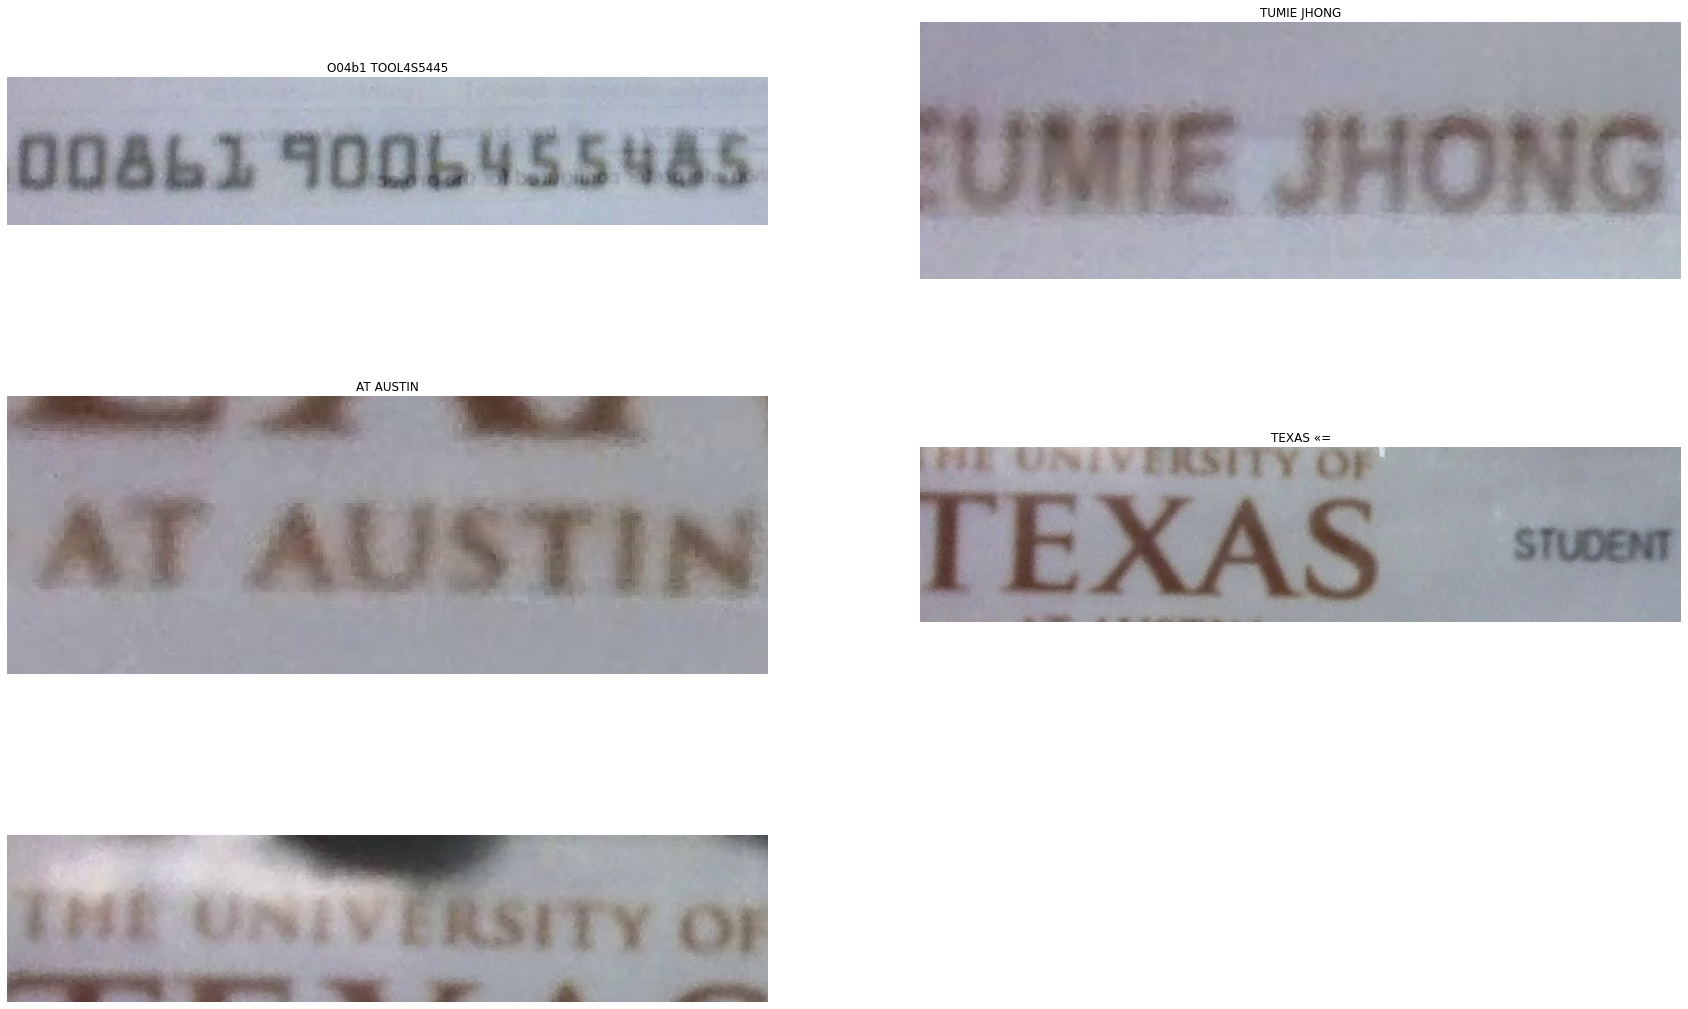

In [25]:
titles = [pytesseract.image_to_string(img) for img in slices]
show_images(slices, titles=titles, cols=3)

In [26]:
narrowed = binarize_images(slices[2:], black_on_white=False)
narrowed = narrow_images(narrowed)

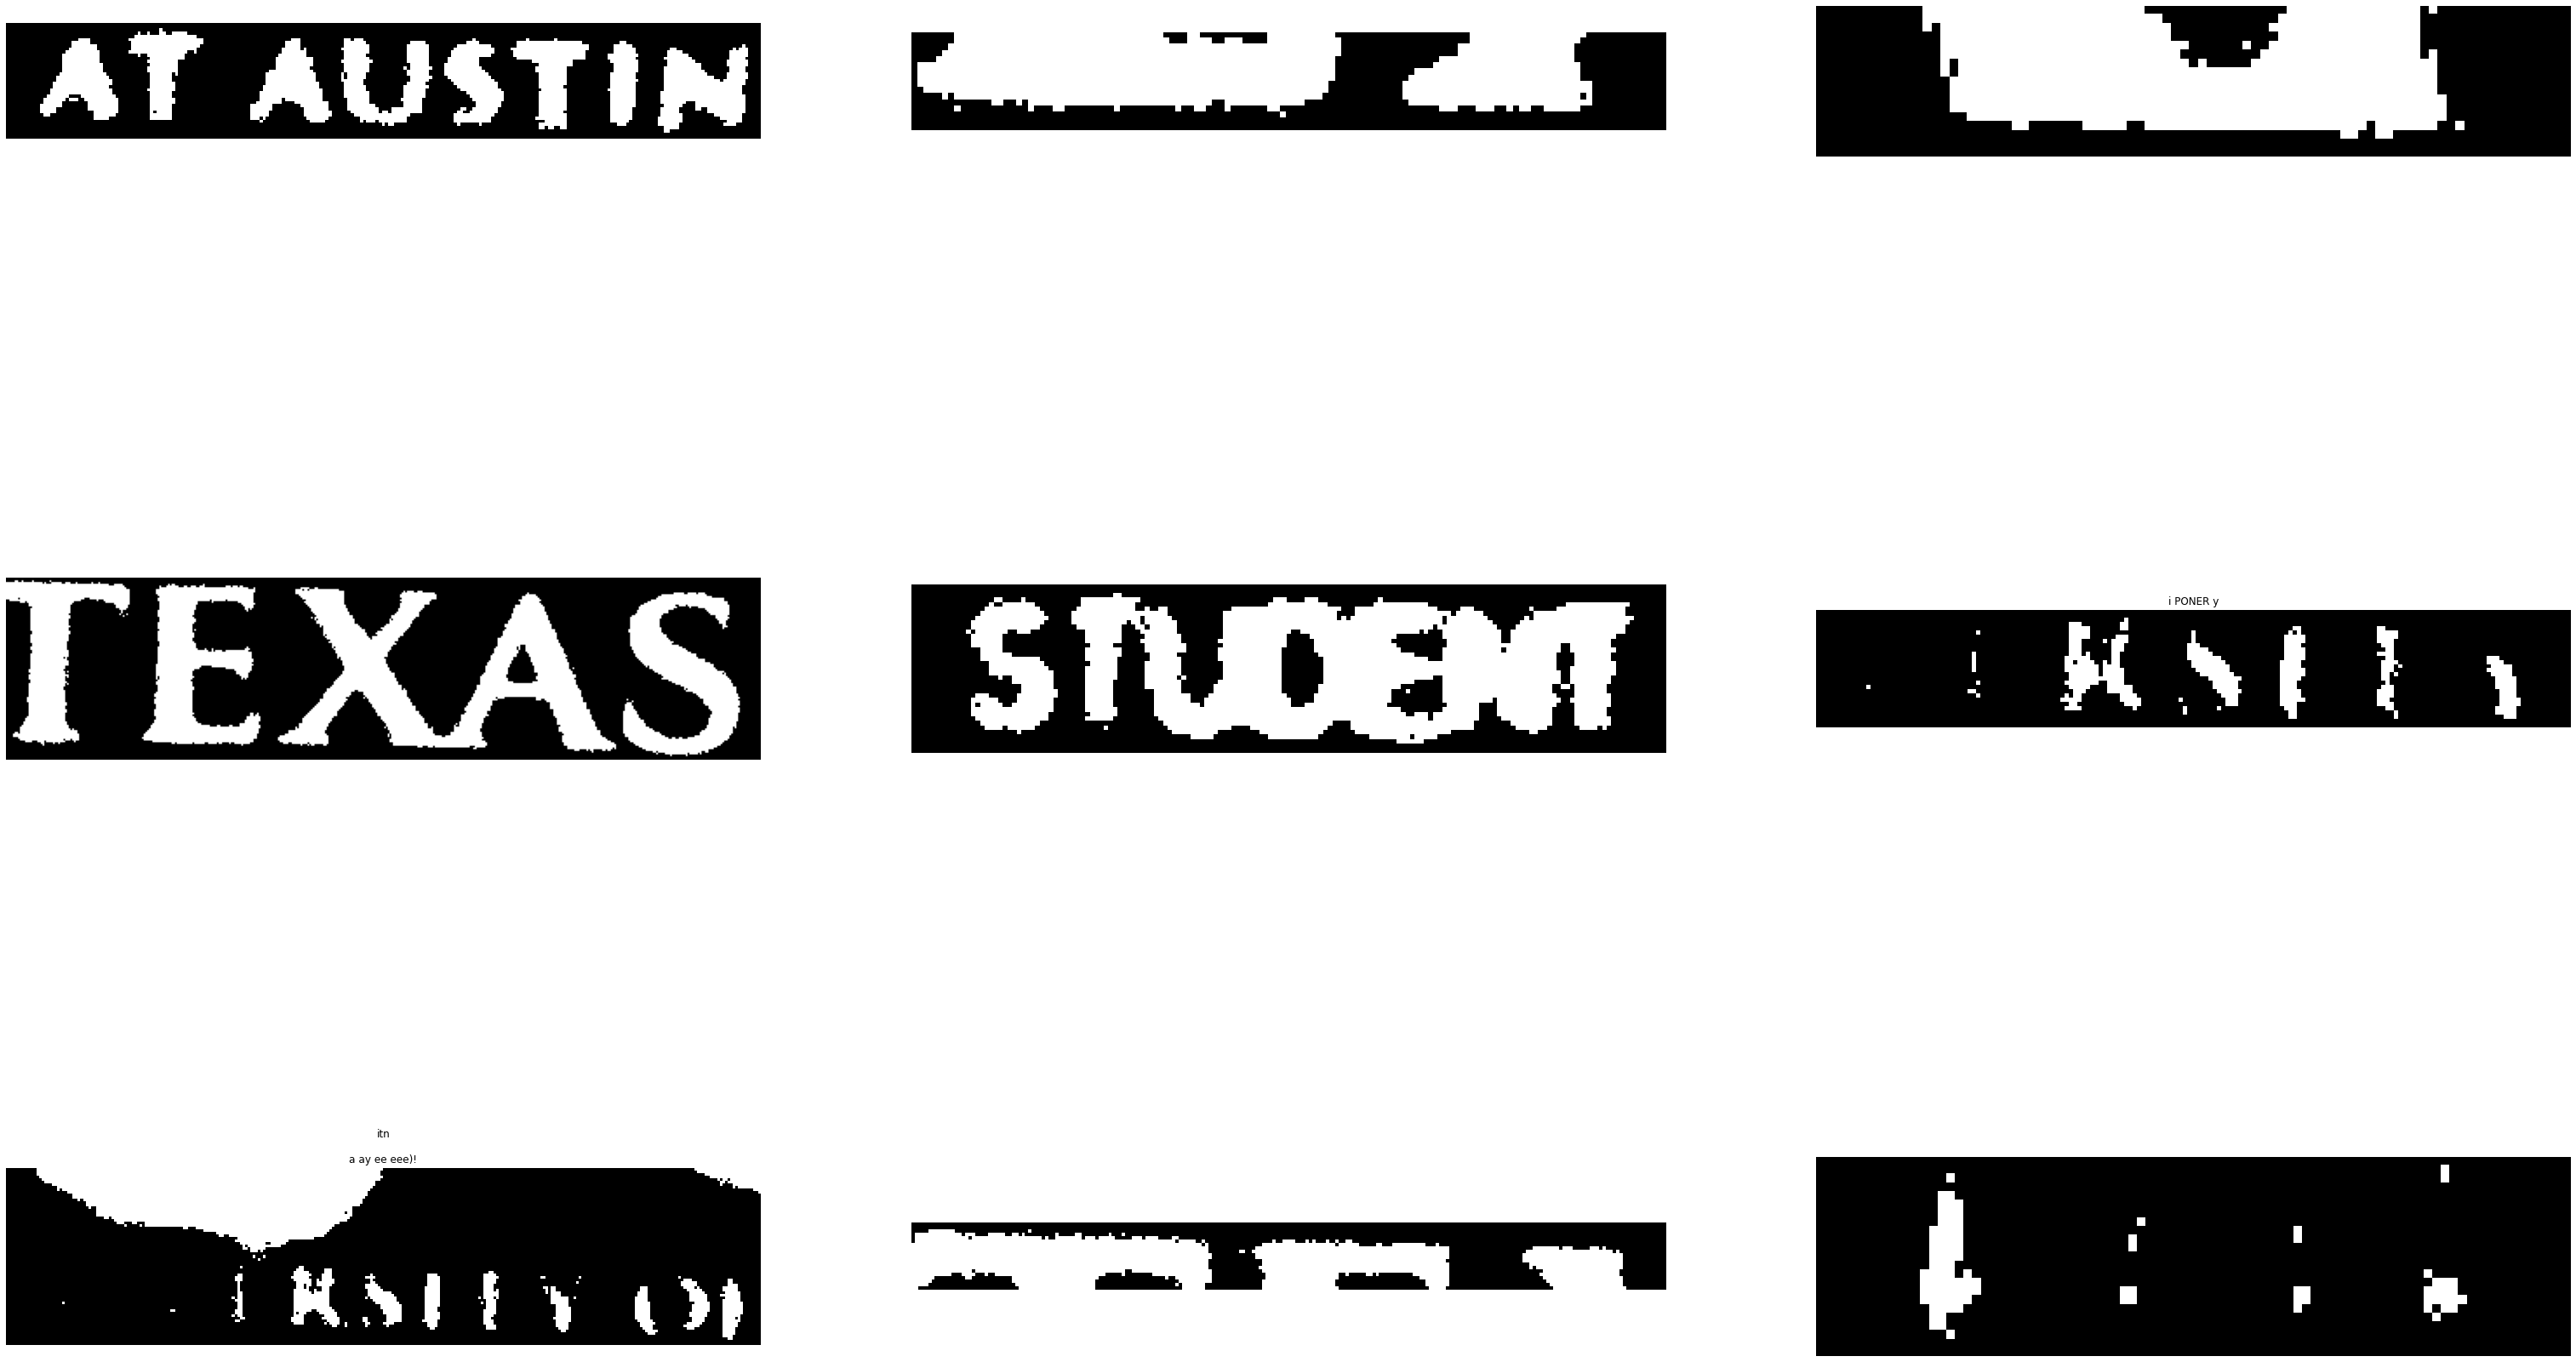

In [27]:
titles = [pytesseract.image_to_string(img) for img in narrowed]
show_images(narrowed, titles=titles, cols=3)

In [28]:
card_2 = load_image(r"/content/drive/My Drive/images/real-ids/frame0097.jpg")
print(pytesseract.image_to_string(card_2))

ll
TEXAS ==

4 AUST!

EUMIE JHONG

2008661 IO0b4SS548S5

SEDAN MEME


In [29]:
detector = EASTDetector()
slices_2 = detector.get_slices(card_2)

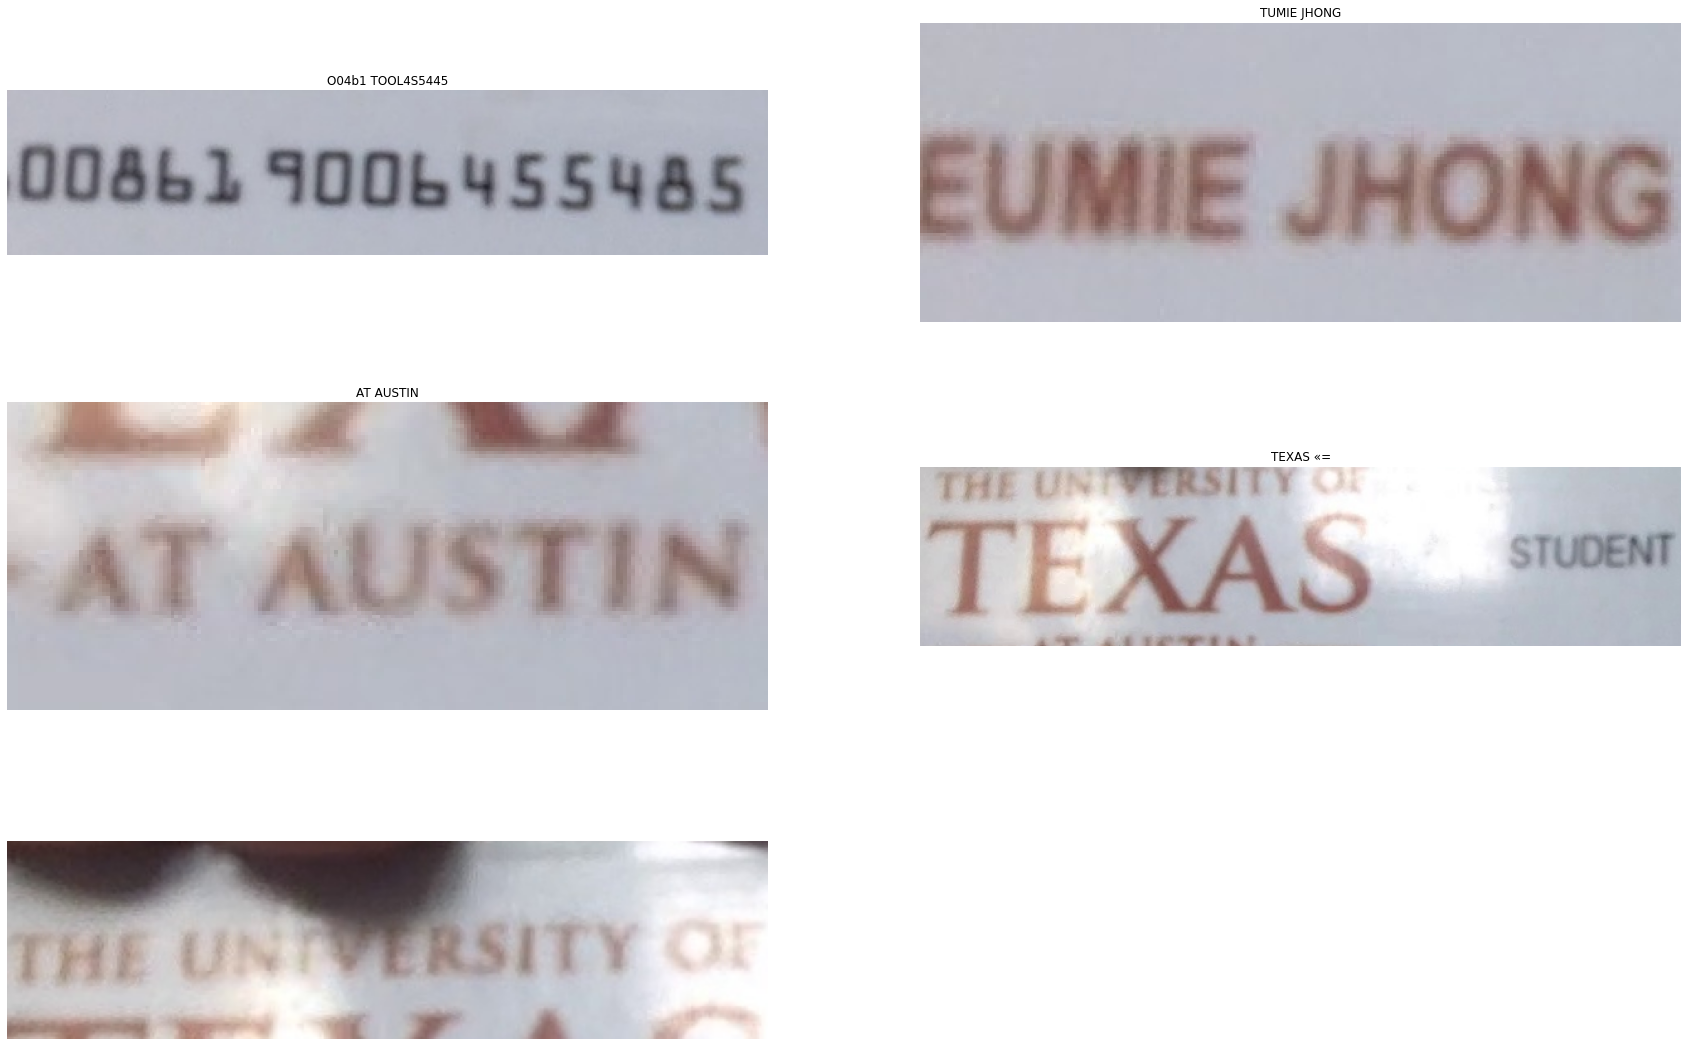

In [30]:
titles_2 = [pytesseract.image_to_string(img) for img in slices]
show_images(slices_2, titles=titles_2, cols=3)

In [31]:
narrowed = binarize_images(slices[2:], black_on_white=False)
narrowed = narrow_images(narrowed)

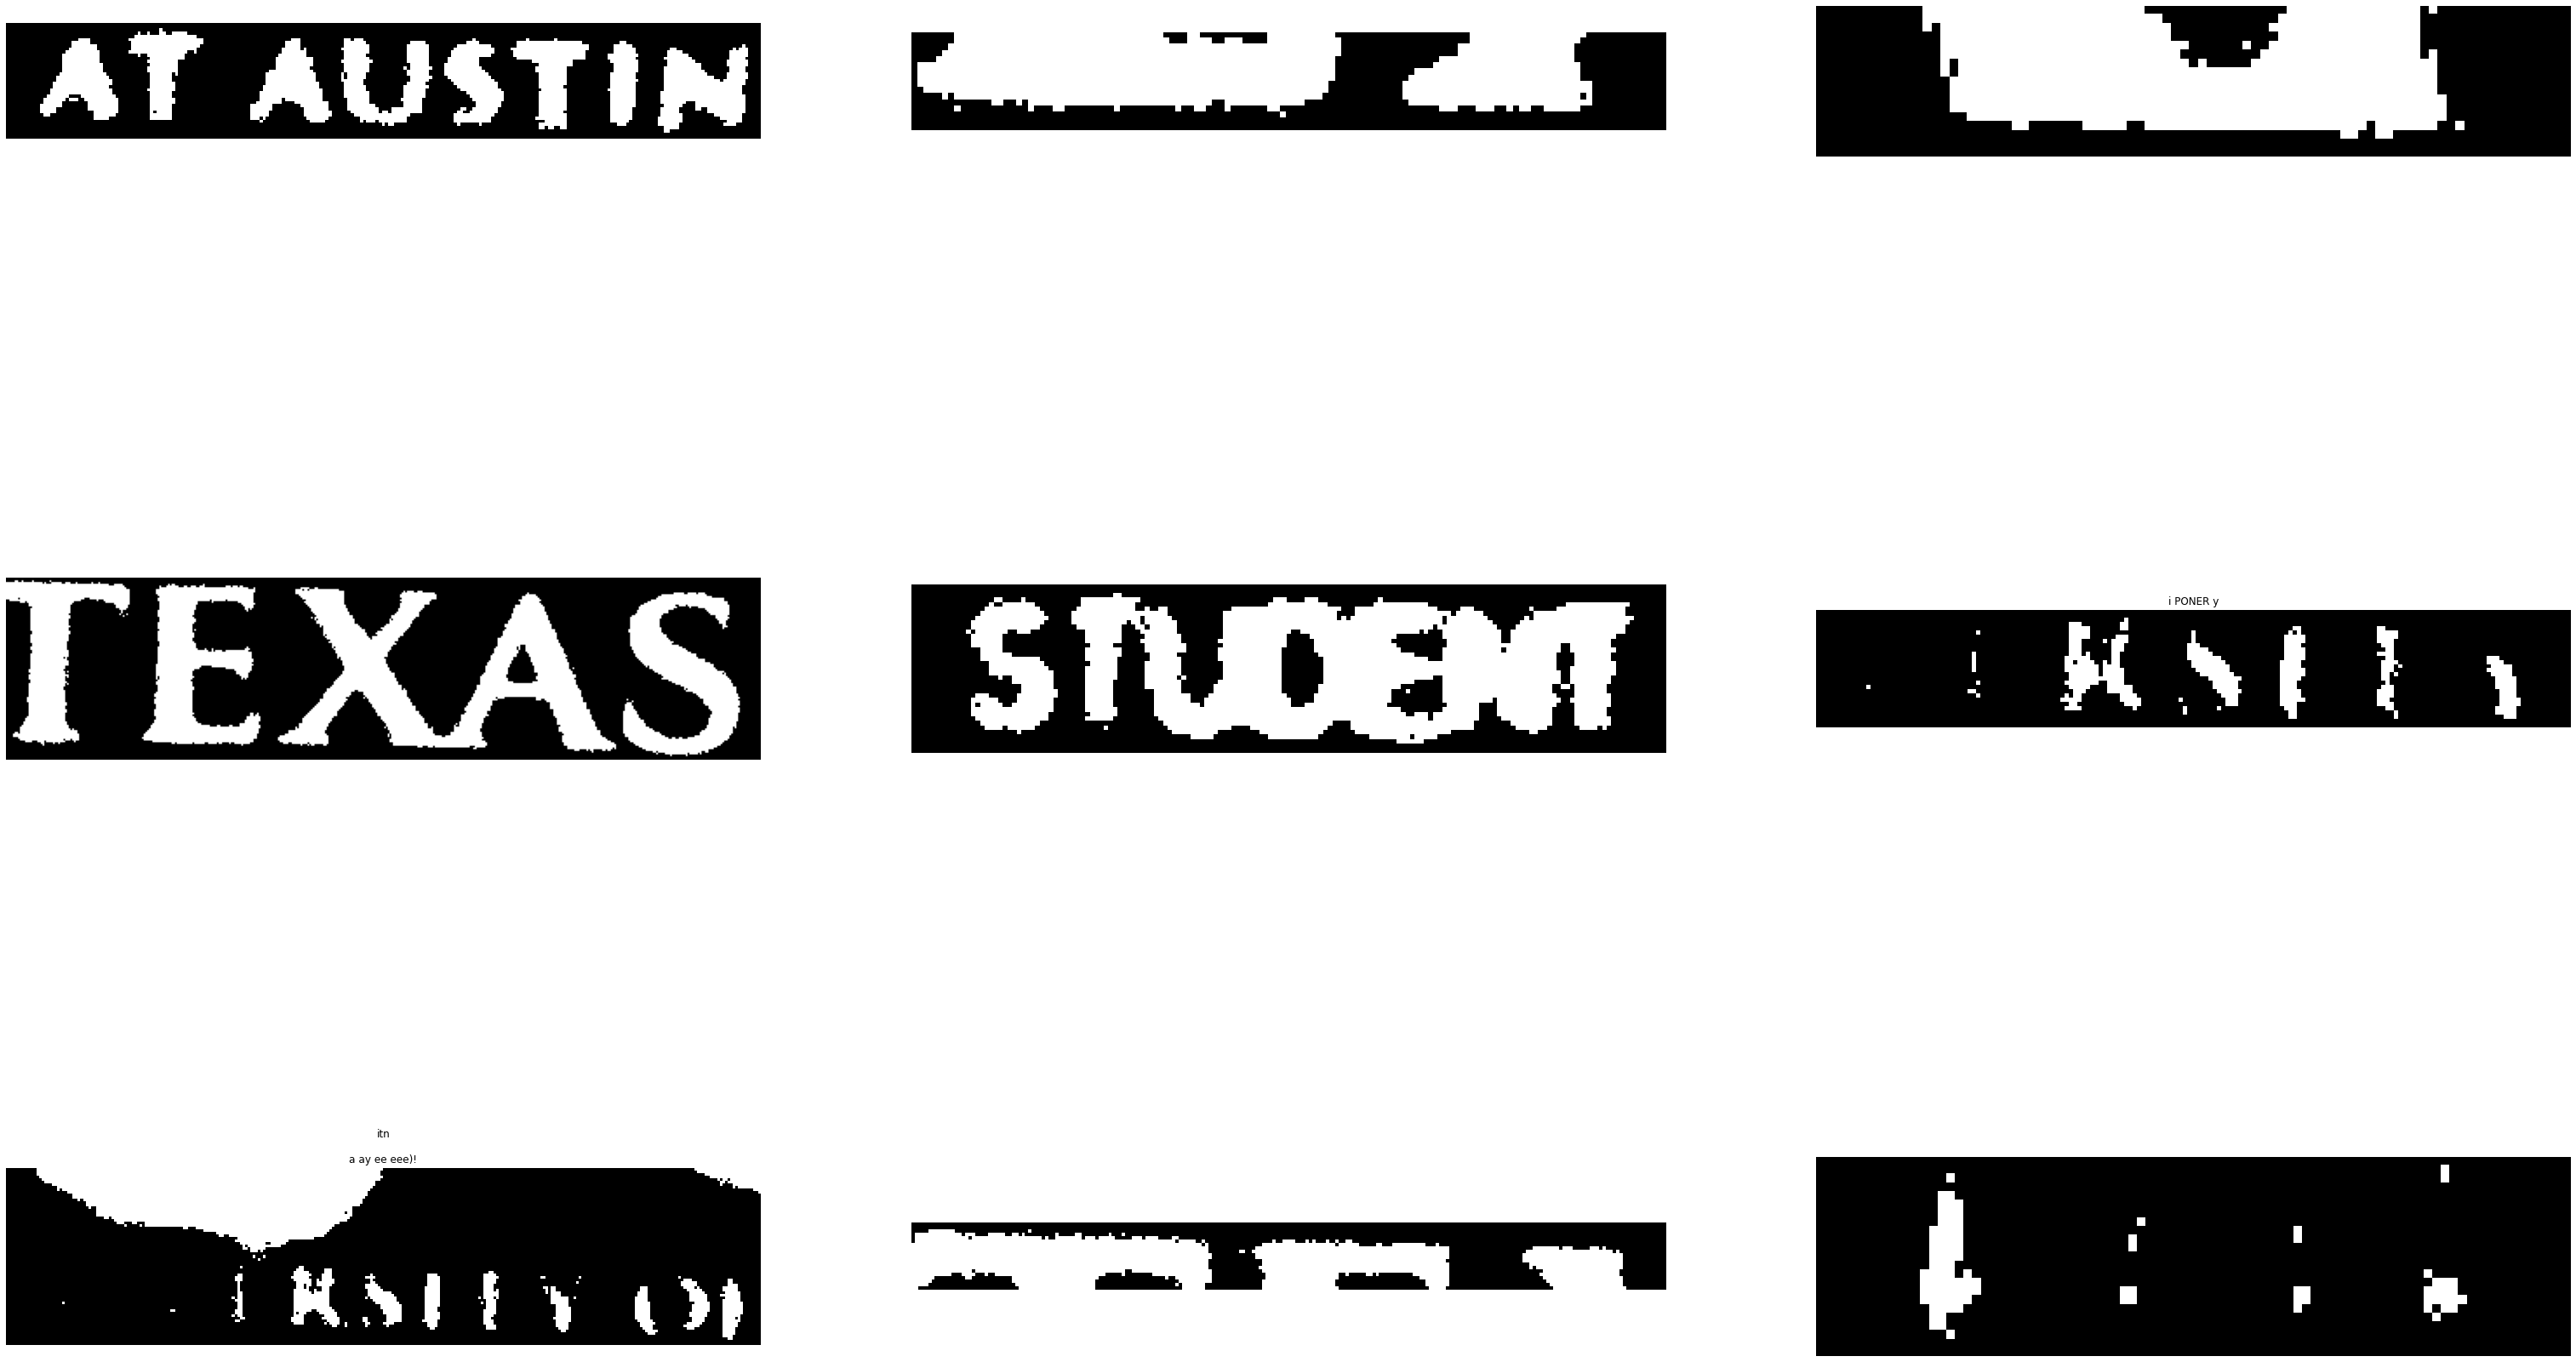

In [32]:
titles = [pytesseract.image_to_string(img) for img in narrowed]
show_images(narrowed, titles=titles, cols=3)

In [33]:
books = load_image("/content/drive/My Drive/images/fake_ids/frame0195.jpg")
detector = EASTDetector()
slices = detector.get_slices(books)
img = slices[-1]

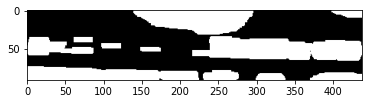

In [34]:
processed = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)           
_, processed = cv2.threshold(processed, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
if np.mean(processed) > 127:
    processed = cv2.bitwise_not(processed)

box_kernel = np.ones((5, 25), np.uint8)
dilation = cv2.dilate(processed, box_kernel, iterations = 1)
bounds, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
"""
for cnt in bounds:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1)
"""    
plt.imshow(dilation, cmap='gray')

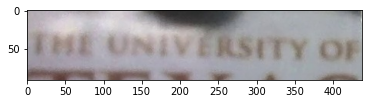

In [35]:
plt.imshow(img)

In [36]:
books_2 = load_image("/content/drive/My Drive/images/real-ids/frame0180.jpg")
detector = EASTDetector()
slices = detector.get_slices(books_2)
img_2 = slices[-1]

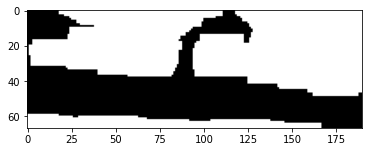

In [37]:
processed = cv2.cvtColor(img_2, cv2.COLOR_RGB2GRAY)           
_, processed = cv2.threshold(processed, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
if np.mean(processed) > 127:
    processed = cv2.bitwise_not(processed)

box_kernel = np.ones((5, 25), np.uint8)
dilation = cv2.dilate(processed, box_kernel, iterations = 1)
bounds, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
"""
for cnt in bounds:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(img_2, (x, y), (x+w, y+h), (0, 255, 0), 1)
"""    
plt.imshow(dilation, cmap='gray')

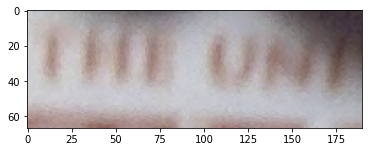

In [38]:
plt.imshow(img_2)

In [39]:
import numpy as np
from skimage import io, color
from skimage.feature import local_binary_pattern

def lbp_histogram(color_image):
    img = color.rgb2gray(color_image)
    patterns = local_binary_pattern(img, 8, 1)
    hist, _ = np.histogram(patterns, bins=np.arange(2**8 + 1), density=True)
    return hist

In [40]:
slice_2_feats = lbp_histogram(img_2)

In [41]:
slice_feats = lbp_histogram(img)

In [42]:
from scipy.spatial.distance import euclidean

euclidean(slice_feats, slice_2_feats)


0.07968387248816476

[]

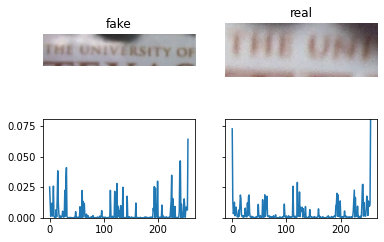

In [43]:
import matplotlib.pyplot as plt

hmax = max([slice_feats.max(), slice_2_feats.max()])
fig, ax = plt.subplots(2, 2)

ax[0, 0].imshow(img)
ax[0, 0].axis('off')
ax[0, 0].set_title('fake')
ax[1, 0].plot(slice_feats)
ax[1, 0].set_ylim([0, hmax])

ax[0, 1].imshow(img_2)
ax[0, 1].axis('off')
ax[0, 1].set_title('real')
ax[1, 1].plot(slice_2_feats)
ax[1, 1].set_ylim([0, hmax])
ax[1, 1].axes.yaxis.set_ticklabels([])


In [44]:
import tensorflow as tf

In [45]:
from sklearn.feature_extraction import image
patches = image.extract_patches_2d(img, (20, 20))

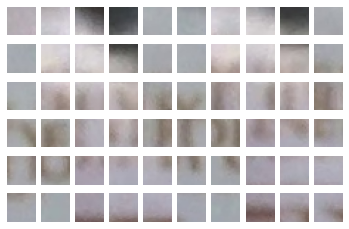

In [46]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(patches[500 * i], cmap='gray')
    axi.axis('off')

In [47]:
patches_2 = image.extract_patches_2d(img_2, (20, 20))

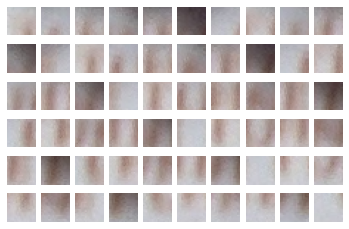

In [48]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(patches_2[100 * i], cmap='gray')
    axi.axis('off')

In [ ]:
"""
This is the part where it slows down and stops running. I'm enumerating over the images and their respective labels 
as well as iterating the EAST function over the images into text slices

"""
import glob
import json
import os
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from json import JSONEncoder
import numpy
fake = glob.glob('/content/drive/My Drive/images/fake_ids/*.jpg')
real = glob.glob('/content/drive/My Drive/images/real-ids/*.jpg')
json_file = '/content/drive/My Drive/image-slices.jsonl'

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

detector = EASTDetector()

Path(json_file).touch()

with open(json_file, 'r') as f:

  already_processed_paths = []
  for line in f:
    line_data = json.loads(line)
    already_processed_paths.append(line_data['path'])

with open(json_file, 'a') as f:

  def output_to_file(image_path, image_slices, label):
    f.write(json.dumps({
        'path': image_path,
        'image_slices': image_slices,
        'label': label
    }, cls=NumpyArrayEncoder))
    f.write("\n")

  for label, image_list in enumerate([fake, real]):
    print(f'Processing list #{label}. {len(image_list)} Files found')

    for image_path in tqdm(image_list):
      if image_path in already_processed_paths:
        continue

      loaded_image = load_image(image_path)
      image_slices = detector.get_slices(loaded_image)
      output_to_file(image_path, image_slices, label)


  0%|          | 0/619 [00:00<?, ?it/s]

Processing list #0. 619 Files found


 32%|███▏      | 198/619 [16:12<35:05,  5.00s/it]

In [ ]:
slices = []
labels = []
json_file = '/content/drive/My Drive/image-slices.jsonl'

with open(json_file, 'r') as f:
  for line in f:
    line_data = json.loads(line)
    slices.append(numpy.asarray(line_data['image_slices']))
    labels.append(line_data['label'])

In [ ]:
#! rm "/content/drive/My Drive/image-slices.jsonl"

In [ ]:
#with open(json_file, 'r') as f:
 # print(f.read())